In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
from skimage import io
%matplotlib inline

# Experiment with convolutions using them directly

See

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [Types of convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)


**Convolution 2D**

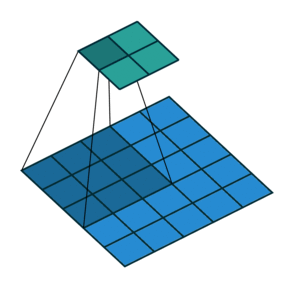

In [3]:
from IPython.display import display, Image
with open('local/imgs/convolution2d.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Convolution 2D Transposed**


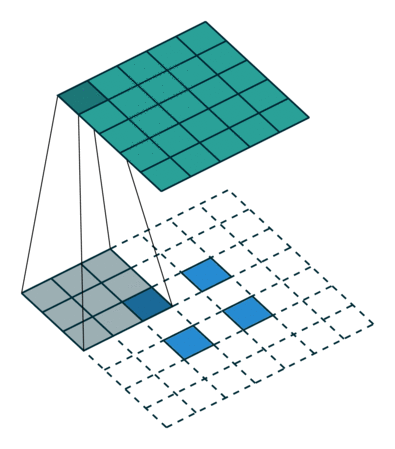

In [4]:
with open('local/imgs/convolution2d-transposed.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### 2d convolution

load an image and one filter

255 0


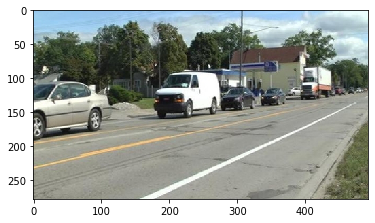

In [5]:
img = io.imread("local/imgs/cars-driving.jpg")
plt.imshow(img)
print (img.max(), img.min())

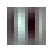

In [6]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
filter_number = 90
akernel = alex_c12[b"conv1"][0][:,:,:,filter_number]
abias   = alex_c12[b"conv1"][1][filter_number]
plt.figure(figsize=(.7,.7))
plt.imshow((akernel-np.min(akernel))/(np.max(akernel)-np.min(akernel)))
plt.axis("off");

In [7]:
akernel.shape

(11, 11, 3)

observe how we do one convolution, setting the weights with the filter we just loaded

In [8]:
c2 = tf.keras.layers.Conv2D(filters=1, kernel_size=(11,11), activation="linear", dtype=tf.float64)
c2.build(input_shape=(None, *img.shape))

In [9]:
w = c2.get_weights()
[i.shape for i in w]

[(11, 11, 3, 1), (1,)]

In [10]:
w[0] = akernel[:,:,:,None]
c2.set_weights(w)

In [11]:
output_img = c2(img[None,:,:,:]/255)

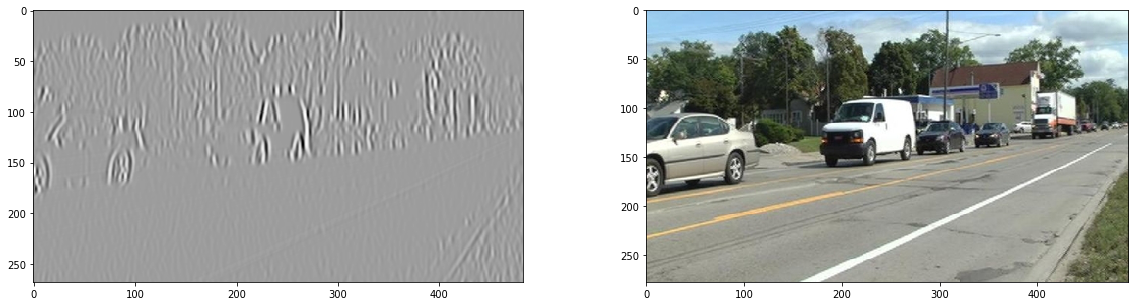

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(output_img[0,:,:,0], cmap=plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(img)

### 1d convolution

observe how we simply apply an untrained layer

In [13]:
input_shape = (None, 6, 1)
c1 = tf.keras.layers.Conv1D(filters=2, kernel_size=3, activation="tanh")
c1.build(input_shape=input_shape)
c1.get_weights()

[array([[[ 0.07131094, -0.10530251]],
 
        [[ 0.11007947,  0.29031396]],
 
        [[-0.09482235,  0.42262566]]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [14]:
size=7
X = np.random.randint(3, size=[size]+list(input_shape)[1:]).astype(np.float32)
X.shape

(7, 6, 1)

In [15]:
X[:,:,0]

array([[0., 2., 0., 0., 0., 1.],
       [1., 2., 2., 0., 2., 1.],
       [2., 1., 0., 1., 0., 2.],
       [1., 2., 1., 2., 2., 0.],
       [2., 0., 1., 0., 0., 0.],
       [2., 1., 1., 0., 2., 0.],
       [0., 1., 2., 1., 1., 2.]], dtype=float32)

In [16]:
X[0,:,0]

array([0., 2., 0., 0., 0., 1.], dtype=float32)

In [17]:
output = c1(X).numpy()
print (output.shape)
output

(7, 4, 2)


array([[[ 0.21666954,  0.52312165],
        [ 0.14166264, -0.2075455 ],
        [ 0.        ,  0.        ],
        [-0.09453916,  0.39914006]],

       [[ 0.10147471,  0.8669272 ],
        [ 0.34766105,  0.35401174],
        [-0.04698819,  0.5612433 ],
        [ 0.12468436,  0.7629572 ]],

       [[ 0.24745627,  0.07954054],
        [-0.02350708,  0.30708447],
        [ 0.10963698,  0.28242376],
        [-0.11778448,  0.6291142 ]],

       [[ 0.19415131,  0.7152988 ],
        [ 0.0629732 ,  0.7282356 ],
        [ 0.10147471,  0.8669272 ],
        [ 0.34766105,  0.35401174]],

       [[ 0.04776315,  0.20889975],
        [ 0.10963698,  0.28242376],
        [ 0.0711903 , -0.104915  ],
        [ 0.        ,  0.        ]],

       [[ 0.15658018,  0.4639512 ],
        [ 0.17942682,  0.182929  ],
        [-0.11778448,  0.6291142 ],
        [ 0.21666954,  0.52312165]],

       [[-0.07939775,  0.81291544],
        [ 0.19415131,  0.7152988 ],
        [ 0.15658018,  0.4639512 ],
        [-0.0082

### doing the convolution by hand


In [18]:
kernels, bias = c1.get_weights()
kernels.shape, bias.shape

((3, 1, 2), (2,))

**first filter output**

In [19]:
output[:,:,0]

array([[ 0.21666954,  0.14166264,  0.        , -0.09453916],
       [ 0.10147471,  0.34766105, -0.04698819,  0.12468436],
       [ 0.24745627, -0.02350708,  0.10963698, -0.11778448],
       [ 0.19415131,  0.0629732 ,  0.10147471,  0.34766105],
       [ 0.04776315,  0.10963698,  0.0711903 ,  0.        ],
       [ 0.15658018,  0.17942682, -0.11778448,  0.21666954],
       [-0.07939775,  0.19415131,  0.15658018, -0.0082541 ]],
      dtype=float32)

**first filter**

In [20]:
kernels[:,0,0]

array([ 0.07131094,  0.11007947, -0.09482235], dtype=float32)

**first filter applied manually to the first input row**

In [21]:
[np.tanh(kernels[:,0,0].dot(X[0,i:i+3,0])) for i in range(4)]

[0.21666954, 0.14166266, 0.0, -0.09453917]

**now for all the input elements and filters**

the loop is for each convolution step

In [22]:
kernel, bias = c1.get_weights()
outputh = np.r_[[np.tanh(X[:,i:i+kernel.shape[0],0].dot(kernel[:,0,:])+bias) \
            for i in range(X.shape[1]-kernel.shape[0]+1)]].swapaxes(0,1).reshape(output.shape)
outputh

array([[[ 0.21666954,  0.5231217 ],
        [ 0.14166266, -0.20754553],
        [ 0.        ,  0.        ],
        [-0.09453917,  0.3991401 ]],

       [[ 0.10147471,  0.86692727],
        [ 0.34766108,  0.35401174],
        [-0.04698819,  0.56124324],
        [ 0.12468437,  0.76295716]],

       [[ 0.24745627,  0.07954055],
        [-0.02350708,  0.3070845 ],
        [ 0.10963698,  0.28242373],
        [-0.11778449,  0.6291142 ]],

       [[ 0.19415133,  0.7152987 ],
        [ 0.06297321,  0.7282355 ],
        [ 0.10147471,  0.86692727],
        [ 0.34766108,  0.35401174]],

       [[ 0.04776315,  0.20889975],
        [ 0.10963698,  0.28242373],
        [ 0.07119031, -0.10491501],
        [ 0.        ,  0.        ]],

       [[ 0.1565802 ,  0.4639512 ],
        [ 0.17942685,  0.18292901],
        [-0.11778449,  0.6291142 ],
        [ 0.21666954,  0.5231217 ]],

       [[-0.07939775,  0.8129154 ],
        [ 0.19415133,  0.7152987 ],
        [ 0.1565802 ,  0.4639512 ],
        [-0.0082

In [23]:
np.allclose(output, outputh)

True

### using a convolution matrix

the filter is transformed into a matrix so that when doing matrix multiplication with the original input, the result contains the elements obtained through a sequential convolution.

In [24]:
def get_conv_matrix(input_shape, kernel):
     return np.r_[[[0]*i+list(kernel)+[0]*(input_shape[1]-kernel.shape[0]-i) \
                   for i in range(input_shape[1]-kernel.shape[0]+1)]]

convolution matrix for the first filter

In [25]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])
print(cm.shape)
cm.T

(4, 6)


array([[-0.10530251,  0.        ,  0.        ,  0.        ],
       [ 0.29031396, -0.10530251,  0.        ,  0.        ],
       [ 0.42262566,  0.29031396, -0.10530251,  0.        ],
       [ 0.        ,  0.42262566,  0.29031396, -0.10530251],
       [ 0.        ,  0.        ,  0.42262566,  0.29031396],
       [ 0.        ,  0.        ,  0.        ,  0.42262566]])

In [26]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.52312166, -0.20754554,  0.        ,  0.3991401 ],
       [ 0.86692728,  0.35401174,  0.56124325,  0.76295719],
       [ 0.07954055,  0.3070845 ,  0.28242376,  0.62911423],
       [ 0.71529874,  0.72823554,  0.86692728,  0.35401174],
       [ 0.20889977,  0.28242376, -0.10491501,  0.        ],
       [ 0.46395121,  0.18292902,  0.62911423,  0.52312166],
       [ 0.81291539,  0.71529874,  0.46395121,  0.77401371]])

and for all the filters together

In [27]:
outputm = np.r_[[np.tanh(X[:,:,0].dot(get_conv_matrix(X.shape, kernel[:,0,i]).T)+bias[i]).T \
          for i in range(kernel.shape[-1])]].swapaxes(2,0).reshape(output.shape)
outputm

array([[[ 0.21666954,  0.52312166],
        [ 0.14166265, -0.20754554],
        [ 0.        ,  0.        ],
        [-0.09453917,  0.3991401 ]],

       [[ 0.10147471,  0.86692728],
        [ 0.34766109,  0.35401174],
        [-0.04698819,  0.56124325],
        [ 0.12468437,  0.76295719]],

       [[ 0.24745628,  0.07954055],
        [-0.02350708,  0.3070845 ],
        [ 0.10963698,  0.28242376],
        [-0.1177845 ,  0.62911423]],

       [[ 0.19415133,  0.71529874],
        [ 0.06297321,  0.72823554],
        [ 0.10147471,  0.86692728],
        [ 0.34766109,  0.35401174]],

       [[ 0.04776316,  0.20889977],
        [ 0.10963698,  0.28242376],
        [ 0.0711903 , -0.10491501],
        [ 0.        ,  0.        ]],

       [[ 0.15658019,  0.46395121],
        [ 0.17942685,  0.18292902],
        [-0.1177845 ,  0.62911423],
        [ 0.21666954,  0.52312166]],

       [[-0.07939775,  0.81291539],
        [ 0.19415133,  0.71529874],
        [ 0.15658019,  0.46395121],
        [-0.0082

In [28]:
np.allclose(outputm, output)

True

### transposed convolution

In [29]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])

direct convolution

In [30]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.52312166, -0.20754554,  0.        ,  0.3991401 ],
       [ 0.86692728,  0.35401174,  0.56124325,  0.76295719],
       [ 0.07954055,  0.3070845 ,  0.28242376,  0.62911423],
       [ 0.71529874,  0.72823554,  0.86692728,  0.35401174],
       [ 0.20889977,  0.28242376, -0.10491501,  0.        ],
       [ 0.46395121,  0.18292902,  0.62911423,  0.52312166],
       [ 0.81291539,  0.71529874,  0.46395121,  0.77401371]])

In [31]:
output.shape, X.shape, cm.shape

((7, 4, 2), (7, 6, 1), (4, 6))

transposed convolution. It recovers the **shape** of the original input (not the content)

In [32]:
tc = output[:,:,0].dot(cm).reshape(X.shape)
tc.T

array([[[-0.02281585, -0.01068554, -0.02605777, -0.02044462,
         -0.00502958, -0.01648829,  0.00836078],
        [ 0.04798476, -0.00715006,  0.07431536,  0.0497336 ,
          0.00232126,  0.02656332, -0.04349489],
        [ 0.13269675,  0.14876465,  0.08621189,  0.08964978,
          0.04451856,  0.13066791,  0.00632103],
        [ 0.06982548,  0.12015958,  0.03429745,  0.01946403,
          0.06700294,  0.01882005,  0.12837992],
        [-0.02744604,  0.0163392 ,  0.01214092,  0.14381667,
          0.03008685,  0.01312345,  0.06377852],
        [-0.03995467,  0.05269481, -0.04977874,  0.14693048,
          0.        ,  0.09157011, -0.0034884 ]]])

In [33]:
X.T

array([[[0., 1., 2., 1., 2., 2., 0.],
        [2., 2., 1., 2., 0., 1., 1.],
        [0., 2., 0., 1., 1., 1., 2.],
        [0., 0., 1., 2., 0., 0., 1.],
        [0., 2., 0., 2., 0., 2., 1.],
        [1., 1., 2., 0., 0., 0., 2.]]], dtype=float32)

In [34]:
X.shape, tc.shape

((7, 6, 1), (7, 6, 1))